In [10]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, Gate
from qiskit import Aer
from typing import Union
from qiskit import assemble, transpile
from qiskit.circuit.library import TwoLocal
import torch
import numpy as np

from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt


In [2]:
# We will implement the efficientSU2 ansatz
def quanvolutionESU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular', insert_barrier=True):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('theta', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims

        qc.compose(entanglement(), range(N_dims), inplace=True)
        
        if (reps == 1 or i == reps-1):
            if insert_barrier: qc.barrier()
            for gate in gates:
                qc.compose(rotation(gate, start), range(N_dims), inplace=True)
                start += N_dims
        if insert_barrier: qc.barrier()
    
    return qc

C:\Users\coshc\anaconda3\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


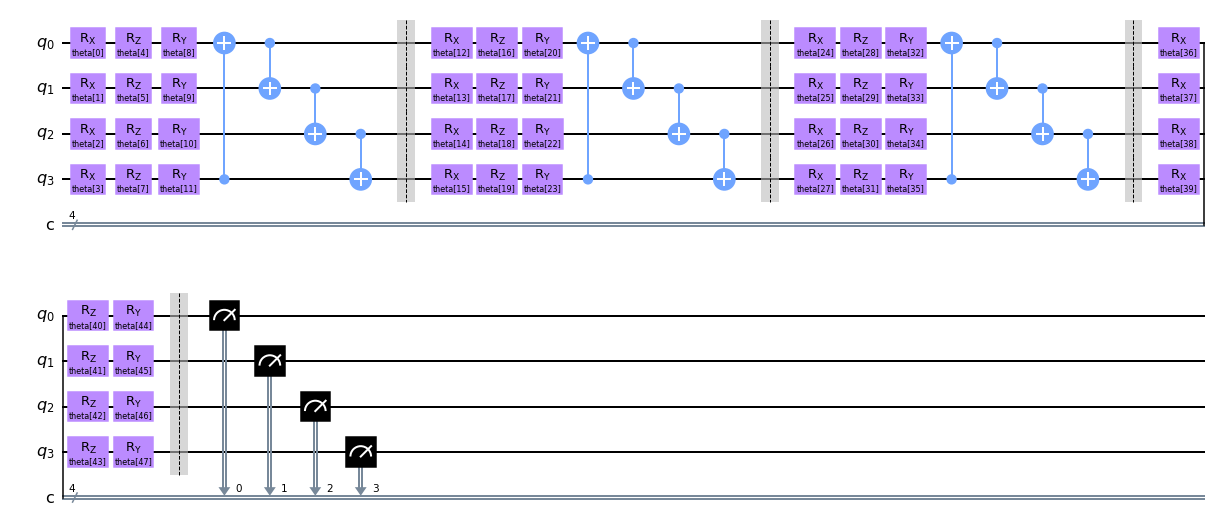

In [3]:
def randomLayer(numQbits, gates=['rx', 'rz', 'ry'], entanglement='linear', reps=1, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(numQbits)
    insert_barrier = False if to_gate else True 
    qc.compose(quanvolutionESU2(numQbits, gates=gates, entanglement=entanglement, reps=reps, 
                                insert_barrier=insert_barrier), inplace=True)
    return qc.to_gate(label="Random Layer") if to_gate else qc

n = 4
qc = QuantumCircuit(n,n)
qc.compose(randomLayer(n, reps=3, to_gate=False, entanglement='circular'), inplace=True)
qc.measure(range(n), range(n))
qc.draw('mpl')

In [4]:
class QC:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = QuantumCircuit(n_qubits).compose(randomLayer(n_qubits))
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = self._circuit.parameters
        self.nParams = self._circuit.num_parameters
        
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta[i]: theta for i,theta in enumerate(thetas)}])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
    


Expected value for rotation pi 4.923828125


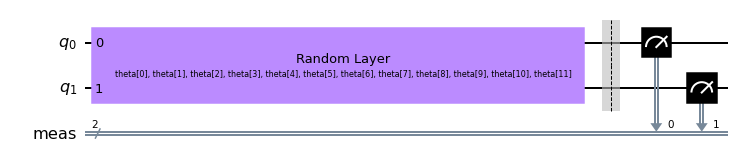

In [29]:
backend = Aer.get_backend('qasm_simulator')
qc = QC(2, backend, 1024)
print('Expected value for rotation pi {}'.format(qc.run([i*np.pi/3 for i in range(qc.nParams)])[0]))
qc._circuit.draw('mpl')


In [22]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.qc = QC(1, backend, shots)
        self.shift = [i*np.pi/3 for i in range(qc.nParams)]
        
    def forward(self, input):
        return HybridFunction.apply(input, self.qc, self.shift)

In [23]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

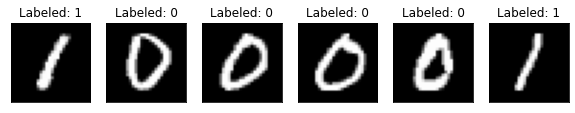

In [24]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [25]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [27]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [dict_keys([ParameterVectorElement(theta[0])])] Circuit parameters: [ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5])])]'